In [1]:
%load_ext autoreload
%autoreload 2
from plotting_report import *
import pickle
from pathlib import Path
import os
import scanpy as sc
import cellink as cl
import pandas as pd
from cellink.tl._burden_testing import *
import warnings
warnings.filterwarnings("ignore")

/data/nasif12/home_if12/l_mai/.conda/envs/mm_scgenetics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
out_path = Path("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/")
eigenvec = pd.read_csv("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/input_data/pcdir/wgs.dose.filtered.R2_0.8.filtered.pruned.eigenvec", sep=' ', header=None)
df_results = pd.read_csv(out_path/ "association/all_results_newest.csv")
df_final = pd.read_csv(out_path/ "association/all_results_FDR_corrected_newest.csv")
df_summary = pd.read_csv(out_path/ "association/all_results_summary_newest.csv")
df_burdens = pd.read_parquet(out_path/"burdens/all_burdens_newest.parquet")

## Get interesting genes

In [3]:
df_filtered = (
    df_final.query("significant")
    .groupby("burden_gene")
    .agg(
        Number_of_Appearence=("celltype-annotation", "nunique"),  # Count unique significant cell types
        Chromosomes=("chromosome", lambda x: ",".join(map(str, sorted(x.unique())))),  # Aggregate unique chromosomes
        Cell_Types=("cell_type", lambda x: ",".join(sorted(x.unique()))),  # Aggregate unique cell types
        Burden_Types=("burden_type", lambda x: ",".join(sorted(x.unique()))),  # Aggregate unique burden types
    )
    .sort_values(by="Number_of_Appearence", ascending=False)  # Sort by highest number of significant cell types
)
df_filtered

Number_of_Appearence Chromosomes  \
burden_gene                                         
ENSG00000124614                    37           6   
ENSG00000145425                    33           4   
ENSG00000204632                    25           6   
ENSG00000036448                    19           8   
ENSG00000102898                    16          16   
...                               ...         ...   
ENSG00000142687                     1           1   
ENSG00000101639                     1          18   
ENSG00000101413                     1          20   
ENSG00000177600                     1          11   
ENSG00000172915                     1          13   

                                                        Cell_Types  \
burden_gene                                                          
ENSG00000124614  B IN,B Mem,CD4 ET,CD4 NC,CD8 ET,CD8 NC,CD8 S10...   
ENSG00000145425  B IN,B Mem,CD4 ET,CD4 NC,CD4 SOX4,CD8 ET,CD8 N...   
ENSG00000204632  B Mem,CD4 ET,CD4 NC,CD8 ET,CD8 NC,CD8 S100B,Mo...   
ENSG00000036448    B IN,CD4 ET,CD4 NC,CD8 ET,CD8 NC,CD8 S100B,NK R   
ENSG00000102898            B Mem,CD4 NC,CD8 ET,CD8 NC,CD8 S100B,NK   
...                                                            ...   
ENSG00000142687                                               NK R   
ENSG00000101639                                             CD4 NC   
ENSG00000101413                                                 DC   
ENSG00000177600                                             CD4 NC   
ENSG00000172915                                                 NK   

                                                      Burden_Types  
burden_gene                                                         
ENSG00000124614  CADD_PHRED,DNA_LM_combined,DNA_LM_down,DNA_LM_...  
ENSG00000145425   CADD_PHRED,GENE_TSS_DISTANCE_SAIGE,MAF_beta_1.25  
ENSG00000204632   CADD_PHRED,GENE_TSS_DISTANCE_SAIGE,MAF_beta_1.25  
ENSG00000036448   CADD_PHRED,GENE_TSS_DISTANCE_SAIGE,MAF_beta_1.25  
ENSG00000102898  CADD_PHRED,DNA_LM_down,DNA_LM_up,GENE_TSS_DIST...  
...                                                            ...  
ENSG00000142687                                         CADD_PHRED  
ENSG00000101639                                      MAF_beta_1.25  
ENSG00000101413                                        DNA_LM_down  
ENSG00000177600                            GENE_TSS_DISTANCE_SAIGE  
ENSG00000172915                                          DNA_LM_up  

[520 rows x 4 columns]

In [ ]:
df_filtered

In [4]:
genes_oi = ["ENSG00000099365", "ENSG00000160445", "ENSG00000132958", "ENSG00000132953", "ENSG00000226816","ENSG00000198520","ENSG00000003147","ENSG00000109184","ENSG00000129691","ENSG00000151729","ENSG00000110203"]

In [5]:
df_gene_oi = df_filtered[df_filtered.index.isin(genes_oi)]
df_gene_oi

Number_of_Appearence Chromosomes     Cell_Types  \
burden_gene                                                        
ENSG00000226816                     9           7  CD4 NC,CD8 NC   
ENSG00000198520                     5           1  CD4 NC,CD8 NC   
ENSG00000160445                     5           9      CD8 S100B   
ENSG00000099365                     5          16         CD4 NC   
ENSG00000110203                     5          11         Mono C   
ENSG00000003147                     5           7         Mono C   
ENSG00000109184                     4           4        Mono NC   
ENSG00000151729                     4           4         Mono C   
ENSG00000132958                     4          13         CD4 NC   
ENSG00000132953                     4          13      CD8 S100B   
ENSG00000129691                     4           8         Mono C   

                                                      Burden_Types  
burden_gene                                                         
ENSG00000226816  CADD_PHRED,DNA_LM_combined,DNA_LM_down,DNA_LM_...  
ENSG00000198520  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...  
ENSG00000160445  CADD_PHRED,DNA_LM_combined,DNA_LM_down,DNA_LM_...  
ENSG00000099365  DNA_LM_combined,DNA_LM_down,DNA_LM_up,GENE_TSS...  
ENSG00000110203  CADD_PHRED,DNA_LM_down,DNA_LM_up,GENE_TSS_DIST...  
ENSG00000003147  CADD_PHRED,DNA_LM_combined,DNA_LM_down,DNA_LM_...  
ENSG00000109184  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...  
ENSG00000151729  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...  
ENSG00000132958  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...  
ENSG00000132953  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...  
ENSG00000129691  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...

## GENE OF INTEREST: ENSG00000110203

In [11]:
df_gene_oi.loc["ENSG00000110203"]["Burden_Types"]

'CADD_PHRED,DNA_LM_down,DNA_LM_up,GENE_TSS_DISTANCE_SAIGE,MAF_beta_1.25'

In [19]:
df_final[df_final["burden_gene"] == "ENSG00000110203"].reset_index()

index  Unnamed: 0      burden_gene      target_gene  \
0   157630      157630  ENSG00000110203  ENSG00000110203   
1   171732      171732  ENSG00000110203  ENSG00000110203   
2   185834      185834  ENSG00000110203  ENSG00000110203   
3   199936      199936  ENSG00000110203  ENSG00000110203   
4   214038      214038  ENSG00000110203  ENSG00000110203   
5   228140      228140  ENSG00000110203  ENSG00000110203   
6   240137      240137  ENSG00000110203  ENSG00000110203   
7   250464      250464  ENSG00000110203  ENSG00000110203   
8   260791      260791  ENSG00000110203  ENSG00000110203   
9   271118      271118  ENSG00000110203  ENSG00000110203   
10  281445      281445  ENSG00000110203  ENSG00000110203   
11  291772      291772  ENSG00000110203  ENSG00000110203   

                burden_type        pvalue      beta cell_type  chromosome  \
0                CADD_PHRED  5.378544e-01 -0.000181    CD4 NC          11   
1                 DNA_LM_up  6.599191e-01 -0.000128    CD4 NC          11   
2               DNA_LM_down  6.661482e-01 -0.000125    CD4 NC          11   
3             MAF_beta_1.25  4.466539e-01 -0.000223    CD4 NC          11   
4           DNA_LM_combined  4.462070e-01 -0.000221    CD4 NC          11   
5   GENE_TSS_DISTANCE_SAIGE  8.673147e-01  0.000049    CD4 NC          11   
6                CADD_PHRED  1.854605e-13  0.418868    Mono C          11   
7                 DNA_LM_up  7.395324e-06  0.254293    Mono C          11   
8               DNA_LM_down  1.140701e-05  0.249120    Mono C          11   
9             MAF_beta_1.25  8.808632e-10  0.349550    Mono C          11   
10          DNA_LM_combined  5.186407e-04  0.197136    Mono C          11   
11  GENE_TSS_DISTANCE_SAIGE  4.988800e-17  0.473133    Mono C          11   

    significant  FDR_corrected             celltype-annotation  
0         False   9.562531e-01               CD4 NC-CADD_PHRED  
1         False   9.968491e-01                CD4 NC-DNA_LM_up  
2         False   9.951087e-01              CD4 NC-DNA_LM_down  
3         False   9.499223e-01            CD4 NC-MAF_beta_1.25  
4         False   9.916293e-01          CD4 NC-DNA_LM_combined  
5         False   9.884332e-01  CD4 NC-GENE_TSS_DISTANCE_SAIGE  
6          True   1.915250e-09               Mono C-CADD_PHRED  
7          True   3.818576e-03                Mono C-DNA_LM_up  
8          True   5.609533e-03              Mono C-DNA_LM_down  
9          True   4.548337e-06            Mono C-MAF_beta_1.25  
10        False   1.245582e-01          Mono C-DNA_LM_combined  
11         True   5.151934e-13  Mono C-GENE_TSS_DISTANCE_SAIGE

In [ ]:
# check expression

In [20]:
save_dir = out_path/"data_plots/gene_oi_ENSG00000110203"
chrom = "11"
gene_oi = "ENSG00000110203"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]

In [26]:
data.adata.obs

orig.ident  nCount_RNA  nFeature_RNA  pool individual  \
barcode                                                                      
AAAGTAGCATCTCCCA-64           0      2353.0           966    62        1_1   
AGCTCCTAGCAGATCG-64           0      4037.0           945    62        1_1   
AGCTCCTAGGGAACGG-64           0      3666.0           965    62        1_1   
GCCAAATCAACTGCTA-64           0      1176.0           492    62        1_1   
AGCTCCTCATTACGAC-64           0      3154.0           784    62        1_1   
...                         ...         ...           ...   ...        ...   
ATTTCTGTCTGCCAGG-57           0      1087.0           501    55  1081_1082   
CGTGTCTTCACATAGC-57           0      3268.0          1141    55  1081_1082   
GCTCCTAAGTAGATGT-57           0      2875.0           897    55  1081_1082   
GCTCCTACAAGGTTTC-57           0      2543.0          1118    55  1081_1082   
TATGCCCTCTCCTATA-57           0      3099.0          1348    55  1081_1082   

                     percent.mt  latent  nCount_SCT  nFeature_SCT  cell_type  \
barcode                                                                        
AAAGTAGCATCTCCCA-64    1.359966       1      2661.0           966          3   
AGCTCCTAGCAGATCG-64    1.634877       1      3117.0           943          4   
AGCTCCTAGGGAACGG-64    1.036552       1      3080.0           964          0   
GCCAAATCAACTGCTA-64    5.272109       1      2652.0           525          3   
AGCTCCTCATTACGAC-64    1.838935       1      2952.0           783          0   
...                         ...     ...         ...           ...        ...   
ATTTCTGTCTGCCAGG-57    4.231831       1      2595.0           535          3   
CGTGTCTTCACATAGC-57    6.303550       1      3034.0          1141         11   
GCTCCTAAGTAGATGT-57    3.339130       1      2875.0           897          5   
GCTCCTACAAGGTTTC-57    3.578451       1      2718.0          1118         14   
TATGCCCTCTCCTATA-57    5.227493       1      2987.0          1348         14   

                    cell_label  sex  age  
barcode                                   
AAAGTAGCATCTCCCA-64     CD8 ET    2   65  
AGCTCCTAGCAGATCG-64     CD8 NC    2   65  
AGCTCCTAGGGAACGG-64     CD4 NC    2   65  
GCCAAATCAACTGCTA-64     CD8 ET    2   65  
AGCTCCTCATTACGAC-64     CD4 NC    2   65  
...                        ...  ...  ...  
ATTTCTGTCTGCCAGG-57     CD8 ET    1   73  
CGTGTCTTCACATAGC-57  Platelets    1   73  
GCTCCTAAGTAGATGT-57  CD8 S100B    1   73  
GCTCCTACAAGGTTTC-57         NK    1   73  
TATGCCCTCTCCTATA-57         NK    1   73  

[1272489 rows x 13 columns]

In [31]:
adata = data.adata.copy()

# Step 1: Extract gene expression for FOLR3
gene_name = 'ENSG00000110203'
if gene_name in adata.var_names:
    gene_expression = adata[:, gene_name].X.toarray().flatten()  # Assuming sparse matrix
    
    # Step 2: Define "high expression" using a threshold (e.g., 95th percentile)
    high_expression_threshold = np.percentile(gene_expression, 95)  # top 5% as high expression
    high_expression_cells = gene_expression > high_expression_threshold
    
    # Step 3: Add a boolean column to adata.obs indicating high expression
    adata.obs['high_expression'] = high_expression_cells
    
    # Step 4: Group by cell type and count the number of high expression cells
    high_expression_per_cell_type = adata.obs.groupby('cell_label')['high_expression'].sum()
    
    # Step 5: Display the result
    print(high_expression_per_cell_type)
    # Step 2: Define expression as non-zero
    expressed_cells = gene_expression > 0  # True for cells with expression > 0
    
    # Step 3: Add a boolean column to adata.obs indicating if the gene is expressed
    adata.obs['gene_expressed'] = expressed_cells
    
    # Step 4: Group by cell type and count the number of cells where the gene is expressed
    expressed_per_cell_type = adata.obs.groupby('cell_label')['gene_expressed'].sum()
    
    # Step 5: Display the result
    print(expressed_per_cell_type)
else:
    print(f"Gene {gene_name} not found in the dataset.")


cell_label
B IN              39
B Mem             36
CD4 ET            25
CD4 NC           218
CD4 SOX4           3
CD8 ET           102
CD8 NC            75
CD8 S100B         14
DC                84
Erythrocytes       1
Mono C          6051
Mono NC           91
NK                76
NK R               0
Plasma             9
Platelets        114
Name: high_expression, dtype: int64
cell_label
B IN              39
B Mem             36
CD4 ET            25
CD4 NC           218
CD4 SOX4           3
CD8 ET           102
CD8 NC            75
CD8 S100B         14
DC                84
Erythrocytes       1
Mono C          6051
Mono NC           91
NK                76
NK R               0
Plasma             9
Platelets        114
Name: gene_expressed, dtype: int64


In [28]:
total_cells_per_cell_type = adata.obs['cell_label'].value_counts()

# Display the result
print(total_cells_per_cell_type)

cell_label
CD4 NC          463528
CD8 ET          205077
NK              159820
CD8 NC          133482
B IN             82068
CD4 ET           61786
B Mem            48023
Mono C           38233
CD8 S100B        34528
Mono NC          15166
NK R              9677
DC                8690
CD4 SOX4          4065
Platelets         4041
Plasma            3625
Erythrocytes       680
Name: count, dtype: int64


In [30]:
6051/38233

0.1582664190620668

In [33]:
data.gdata.varm[]

AnnData object with n_obs × n_vars = 981 × 619520
    var: 'chrom', 'pos', 'a0', 'a1', 'AF', 'ER2', 'maf', 'R2', 'contig', 'id', 'id_mask', 'quality'
    varm: 'annotations_0', 'annotations_1', 'annotations_2', 'annotations_3', 'annotations_4', 'annotations_5', 'annotations_6', 'annotations_7', 'annotations_8', 'annotations_9', 'annotations_10'

Getting PB CD4 NC
[2025-02-02 18:21:58,914] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-02-02 18:21:58,914] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-02-02 18:21:58,915] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
Getting PB Mono C
[2025-02-02 18:22:01,402] INFO:cellink._core.donordata: Keeping 968/981 donors
[2025-02-02 18:22:01,403] INFO:cellink._core.donordata: Dropping 13/981 donors from genetic data
[2025-02-02 18:22:01,403] INFO:cellink._core.donordata: Dropping 0/968 donors from single-cell data


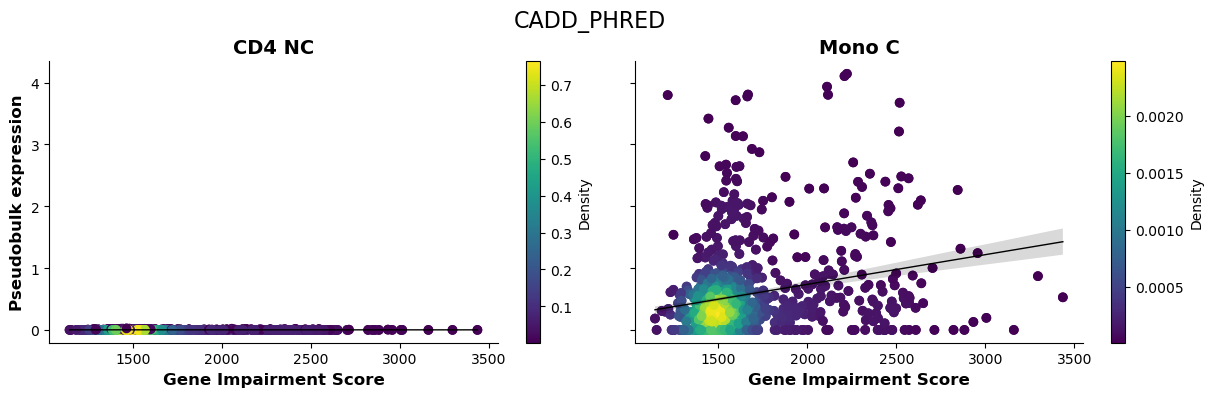

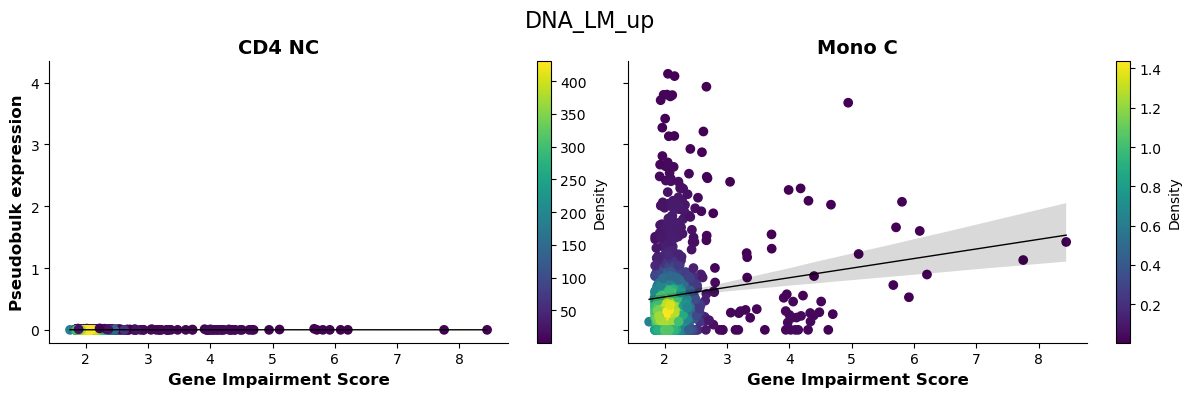

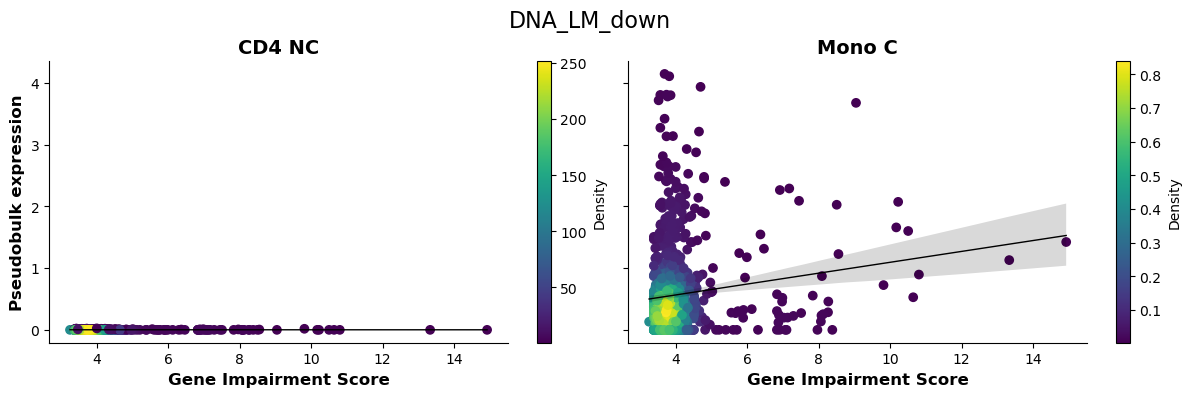

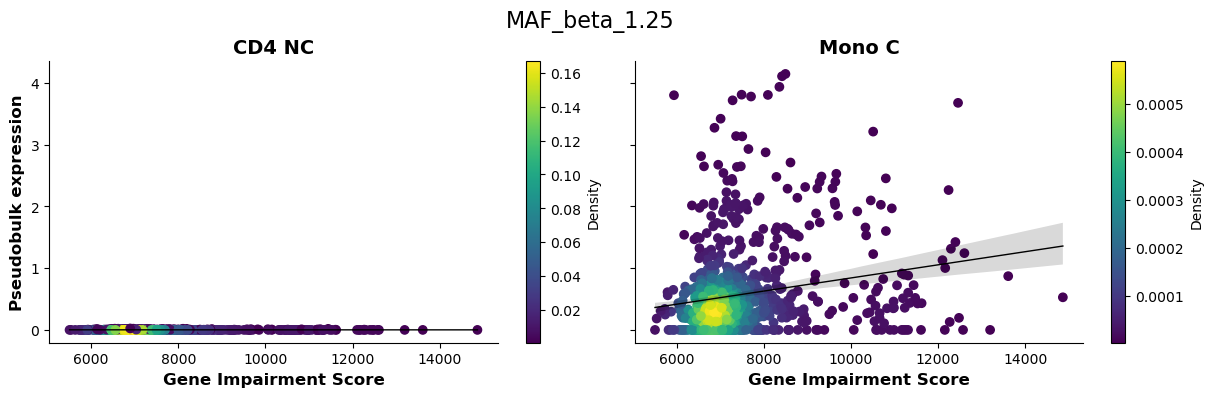

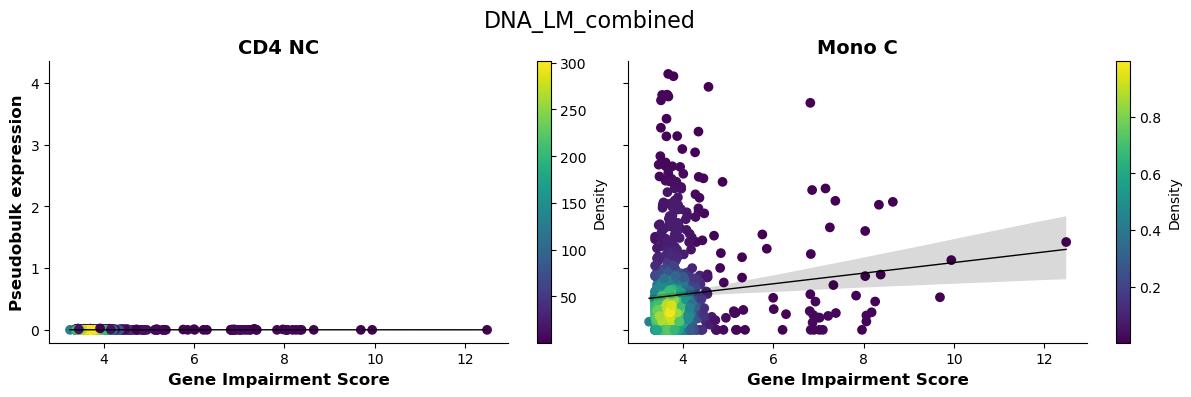

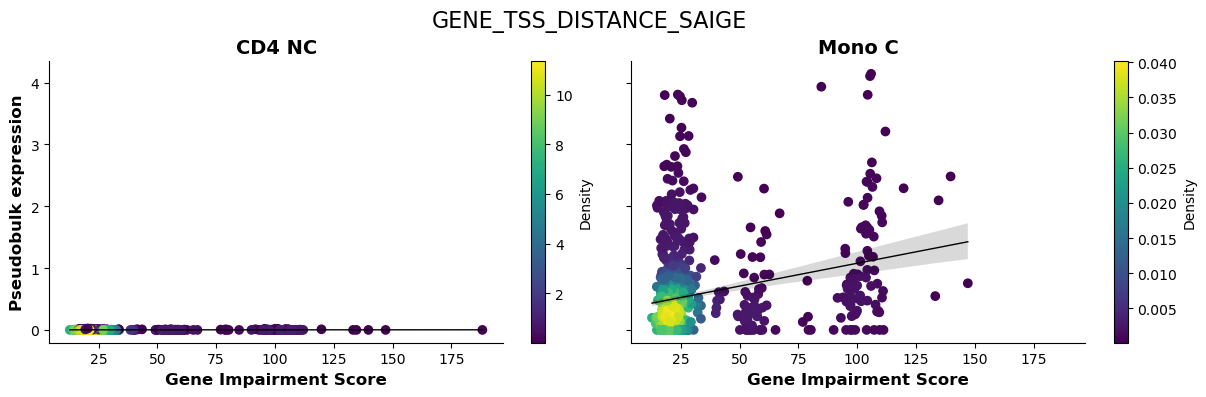

In [8]:
# check expression of pseudobulks
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=["CD4 NC", "Mono C"],#df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             #burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB CD4 NC
[2025-02-02 18:22:43,978] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-02-02 18:22:43,979] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-02-02 18:22:43,980] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


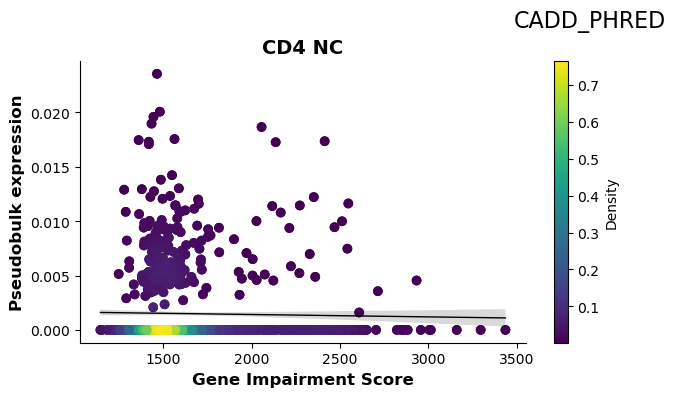

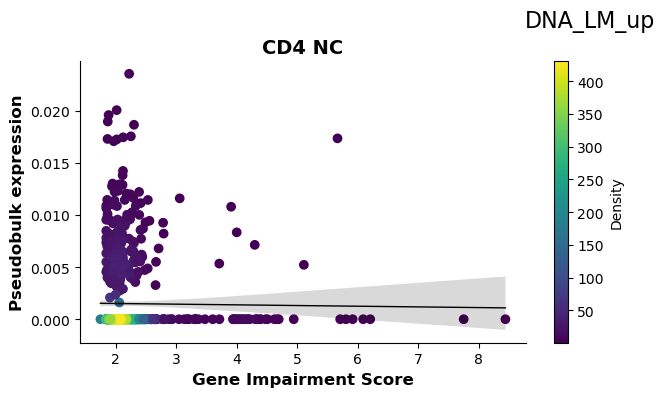

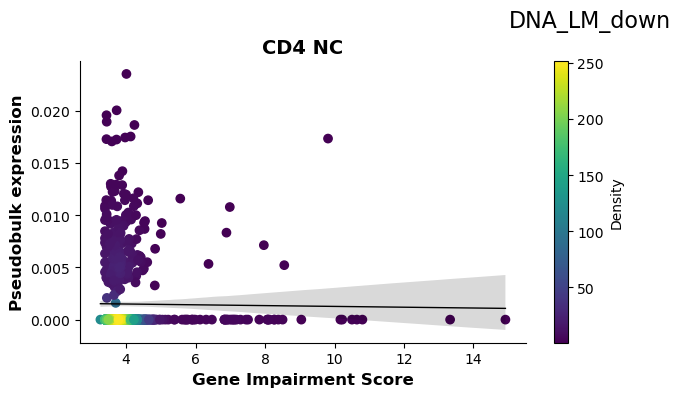

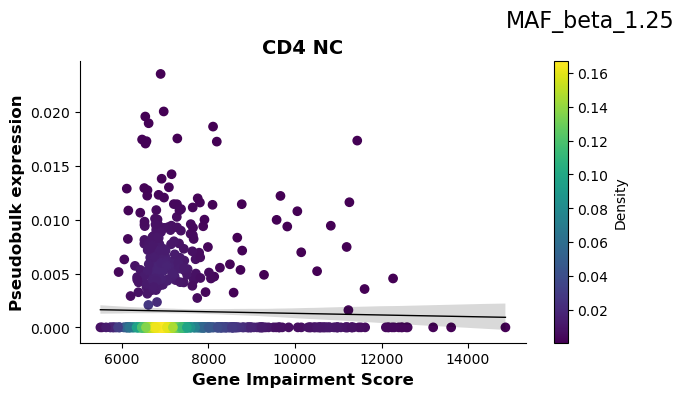

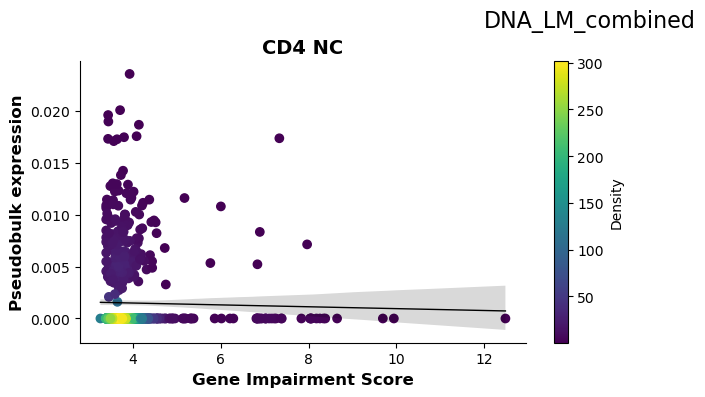

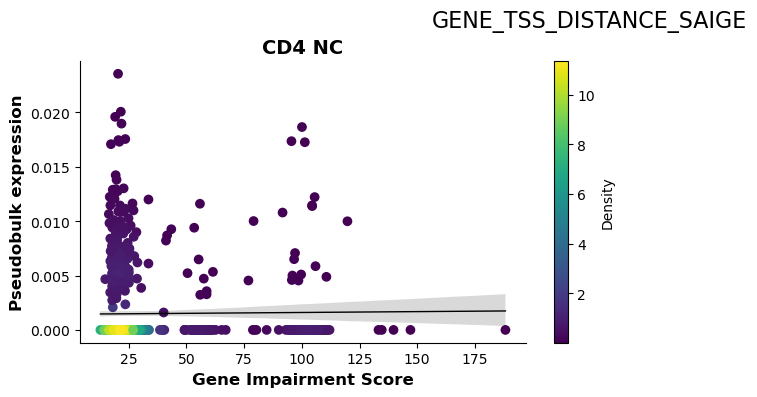

In [9]:
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=["CD4 NC"],#df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             #burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

### OTHER GENES

In [ ]:
save_dir = out_path / "data_plots/pb_expression/gene_oi"

Getting PB CD8 S100B
[2025-01-31 19:05:15,373] INFO:cellink._core.donordata: Keeping 980/981 donors
[2025-01-31 19:05:15,374] INFO:cellink._core.donordata: Dropping 1/981 donors from genetic data
[2025-01-31 19:05:15,375] INFO:cellink._core.donordata: Dropping 0/980 donors from single-cell data


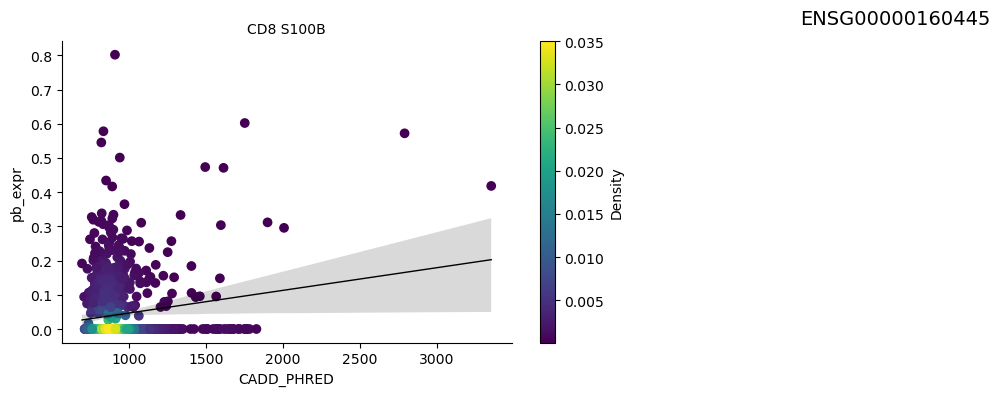

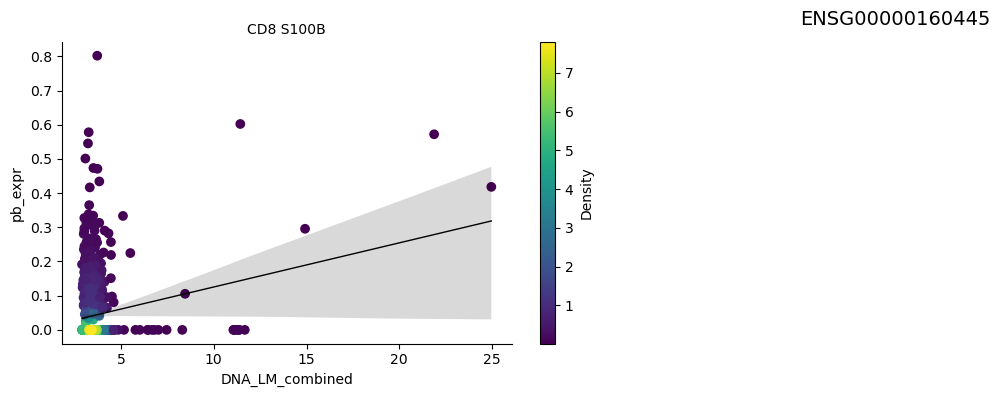

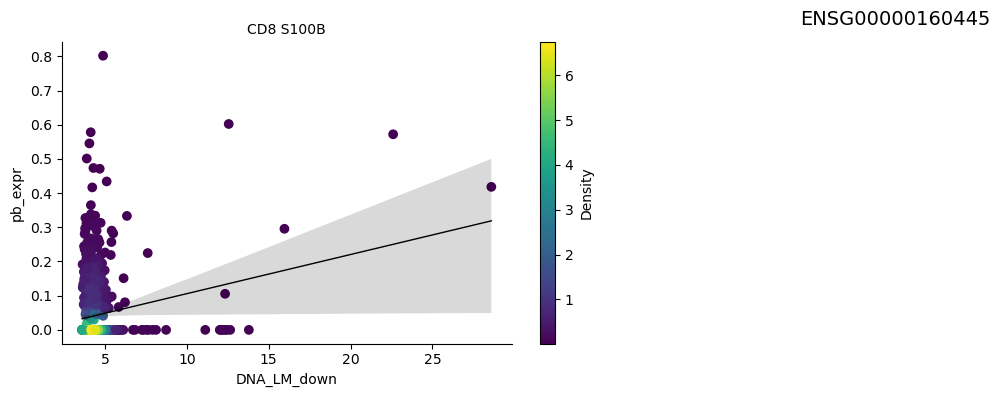

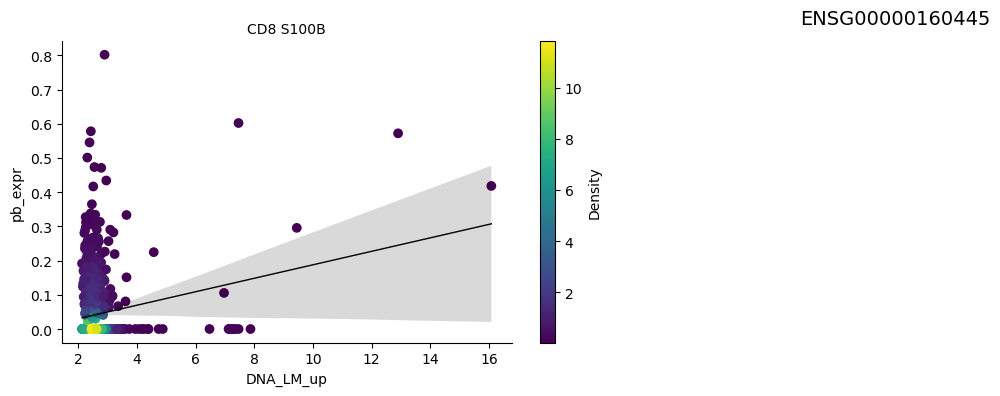

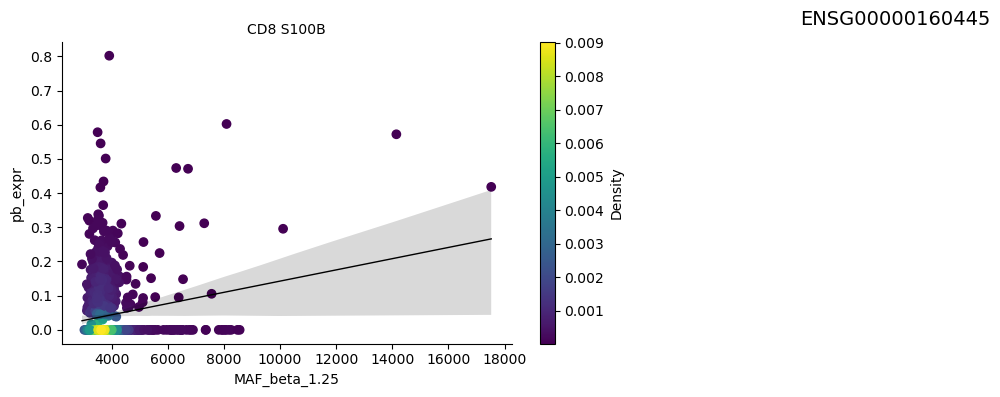

In [96]:
chrom = "9"
gene_oi = "ENSG00000160445"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB CD4 NC
[2025-01-31 19:11:32,755] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-31 19:11:32,755] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-31 19:11:32,755] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


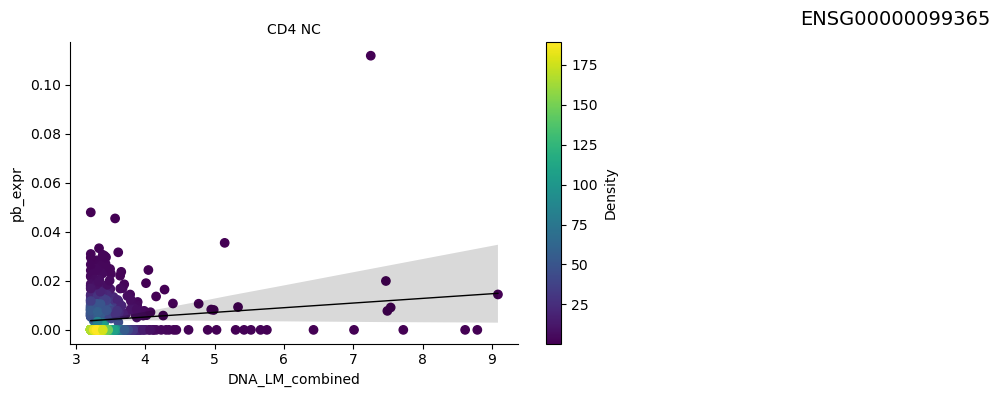

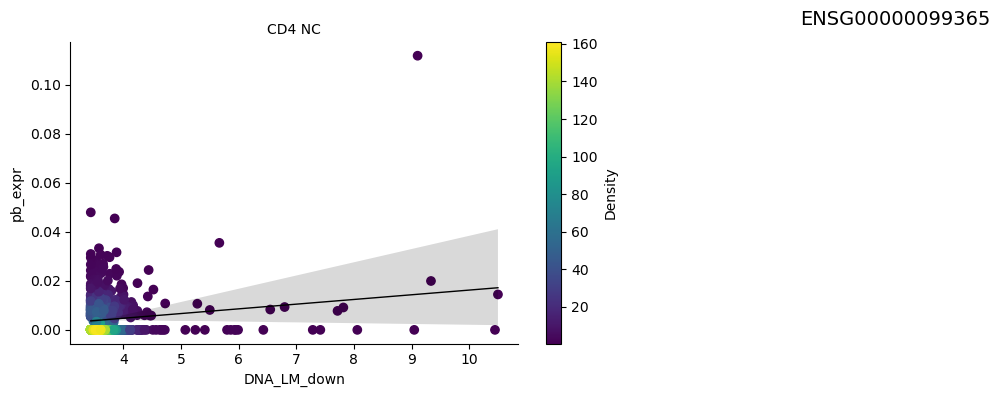

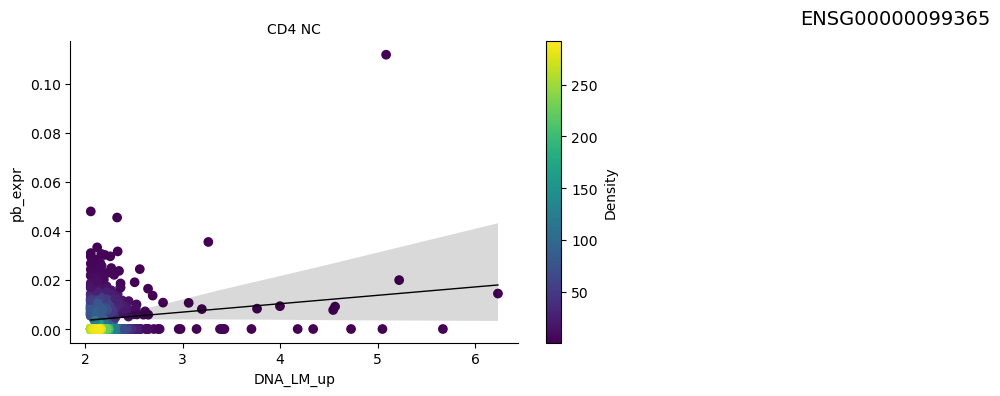

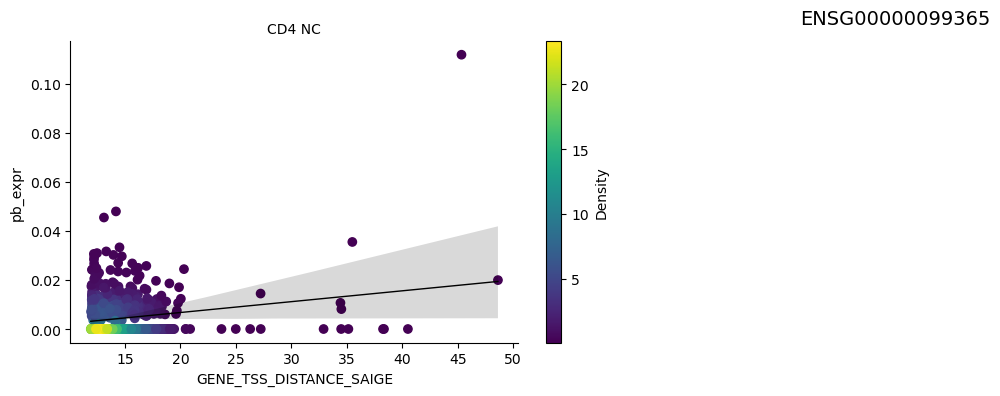

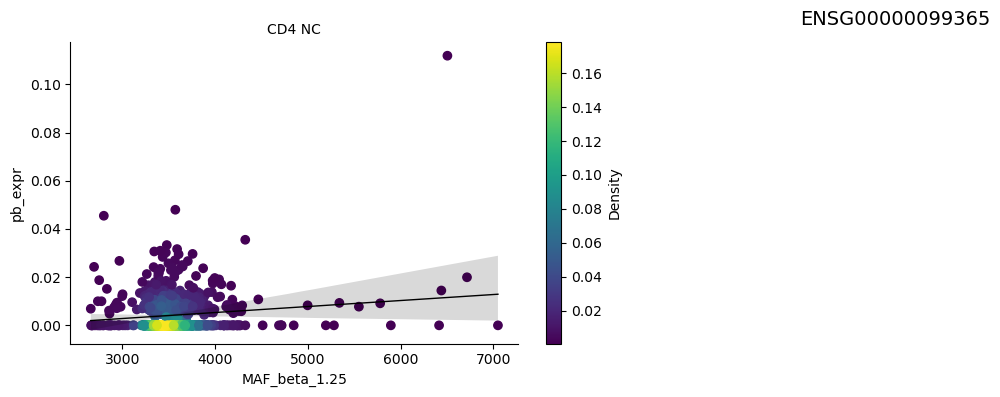

In [97]:
chrom = "16"
gene_oi = "ENSG00000099365"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB CD4 NC
[2025-01-31 19:11:43,168] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-31 19:11:43,169] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-31 19:11:43,169] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


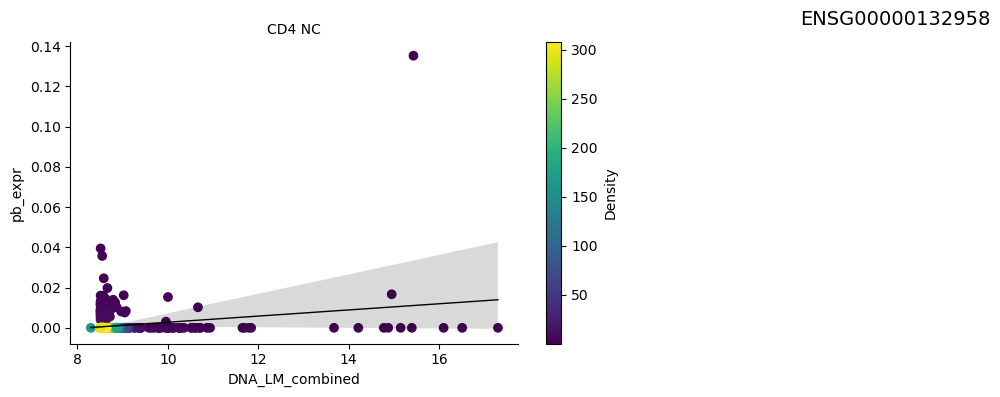

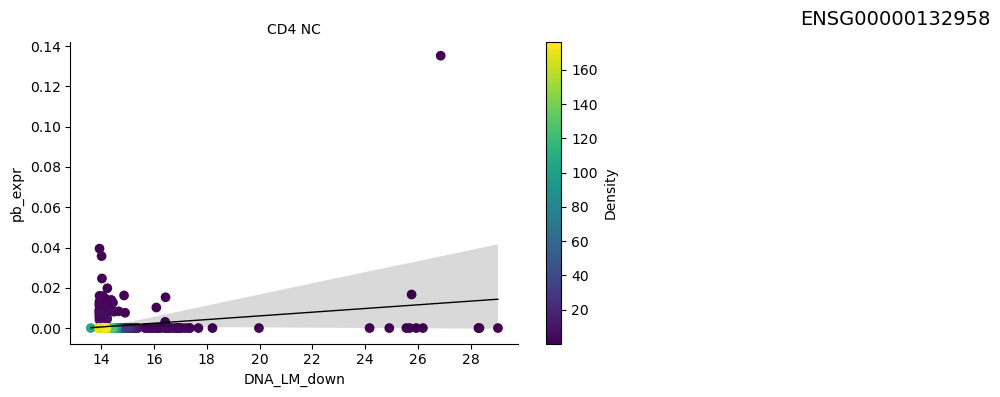

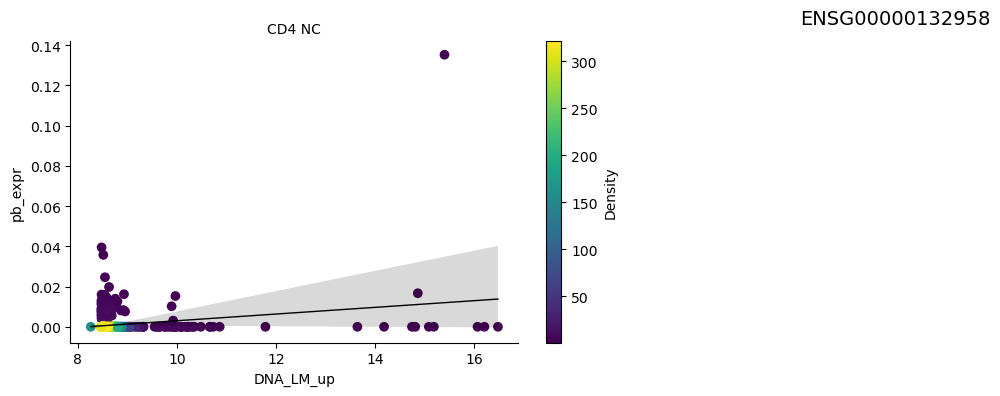

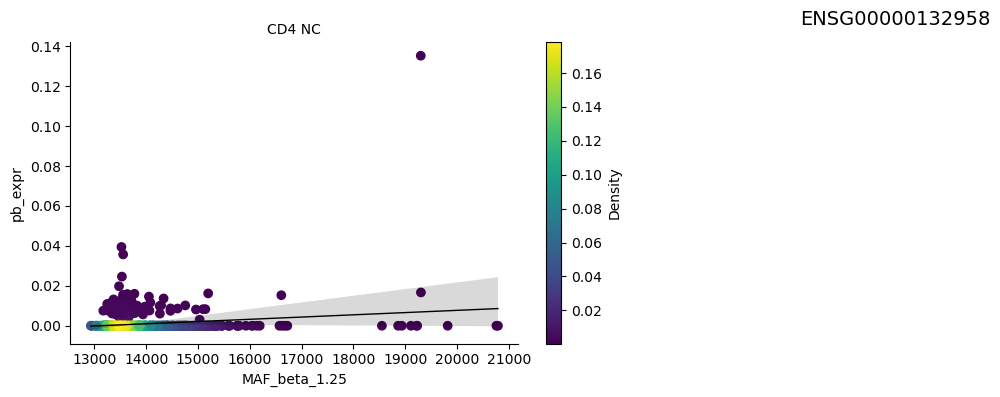

In [98]:
chrom = "13"
gene_oi = "ENSG00000132958"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB CD8 S100B
[2025-01-31 19:12:55,915] INFO:cellink._core.donordata: Keeping 980/981 donors
[2025-01-31 19:12:55,915] INFO:cellink._core.donordata: Dropping 1/981 donors from genetic data
[2025-01-31 19:12:55,916] INFO:cellink._core.donordata: Dropping 0/980 donors from single-cell data


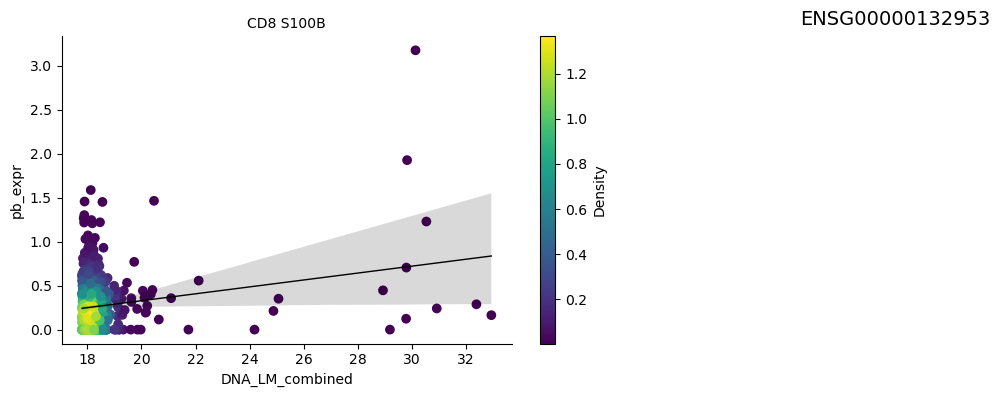

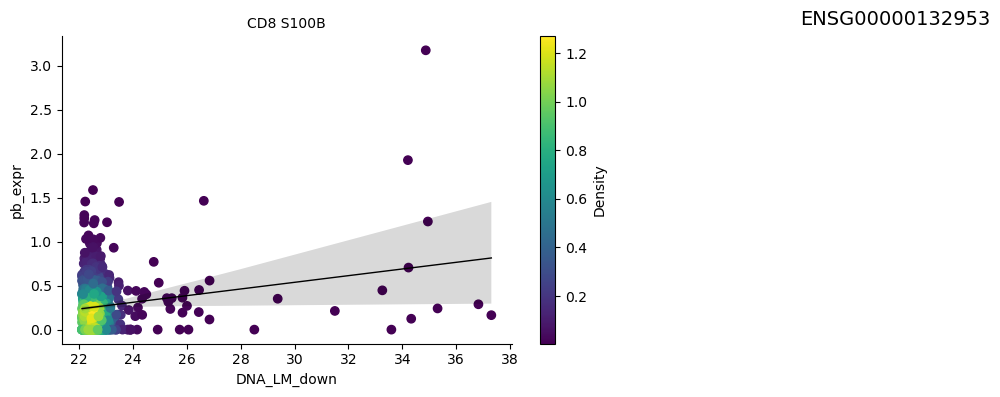

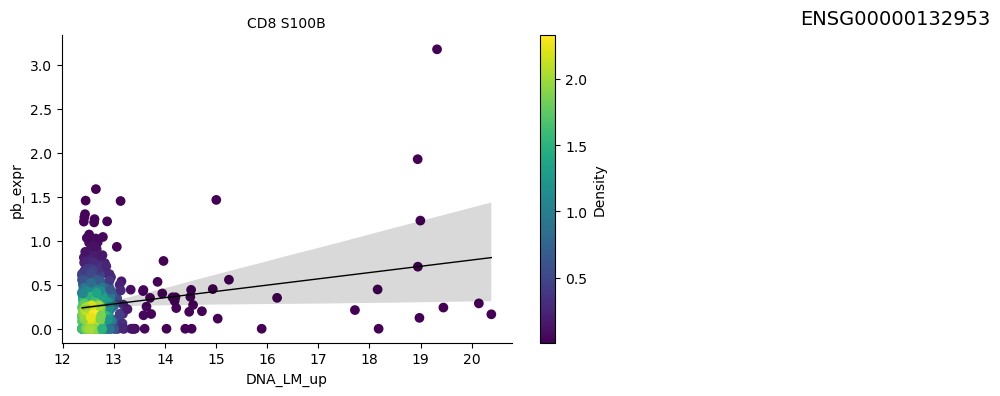

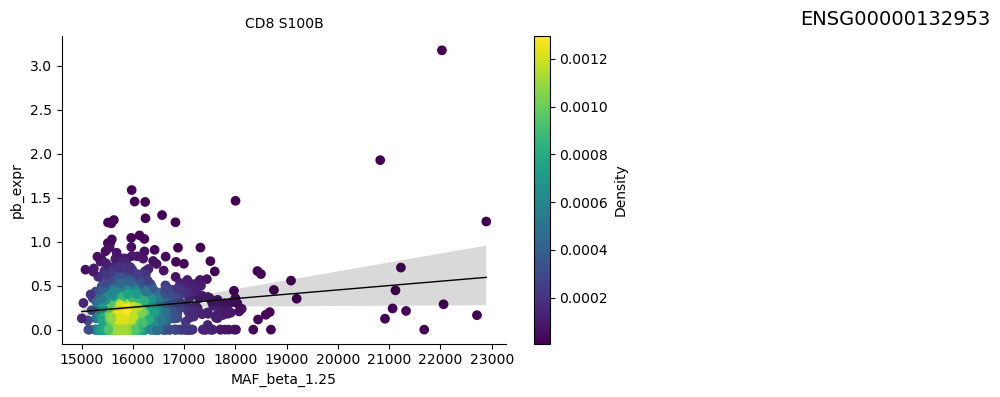

In [101]:
chrom = "13"
gene_oi = "ENSG00000132953"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB CD4 NC
[2025-01-31 19:12:39,298] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-31 19:12:39,299] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-31 19:12:39,299] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
Getting PB CD8 NC
[2025-01-31 19:12:47,659] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-31 19:12:47,660] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-31 19:12:47,660] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


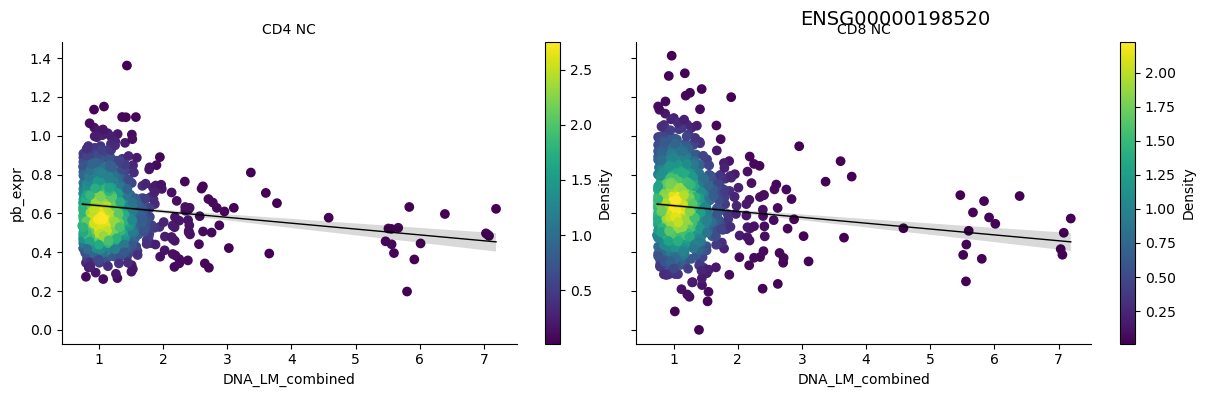

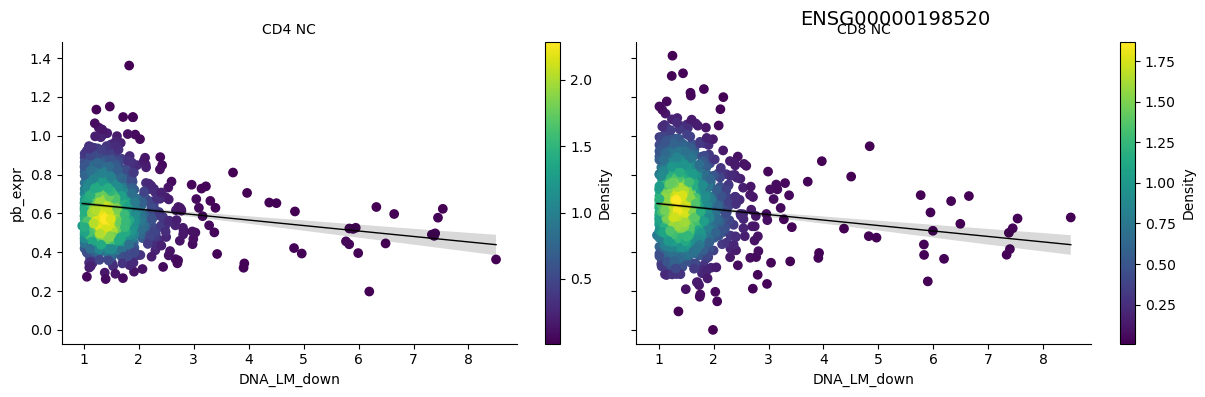

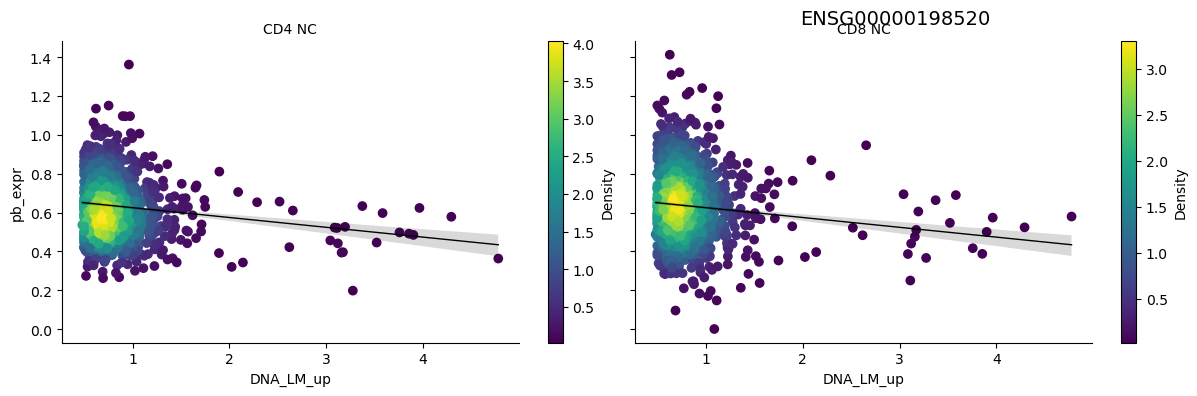

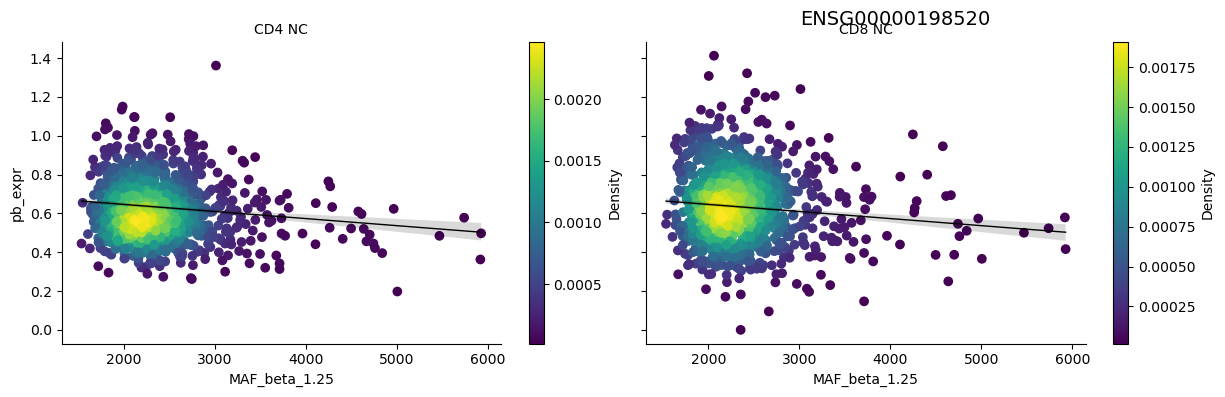

In [100]:
chrom = "1"
gene_oi = "ENSG00000198520"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB CD4 NC
[2025-01-31 19:15:06,943] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-31 19:15:06,944] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-31 19:15:06,944] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
Getting PB CD8 NC
[2025-01-31 19:15:10,483] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-31 19:15:10,484] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-31 19:15:10,484] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


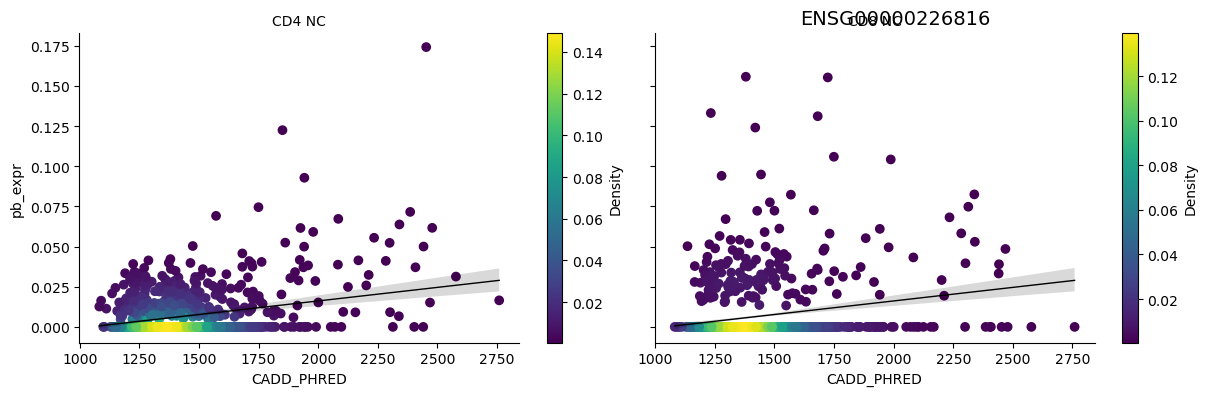

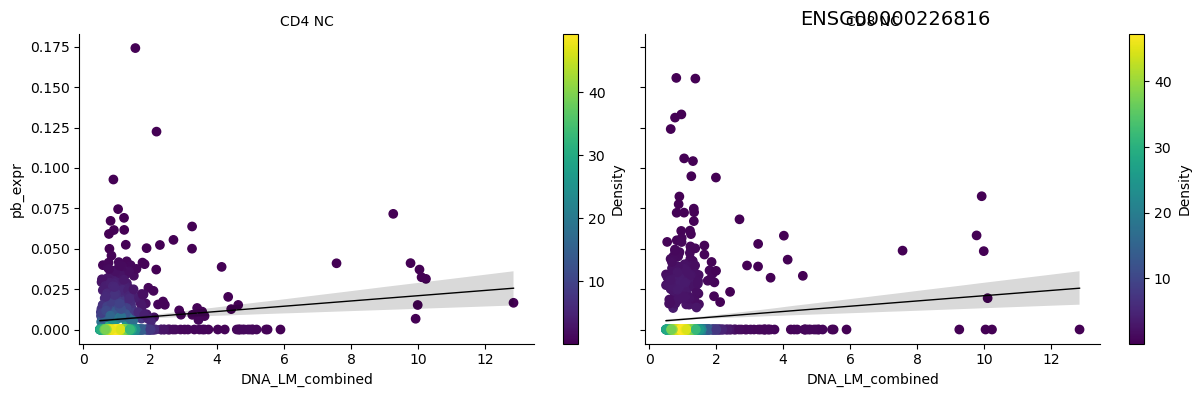

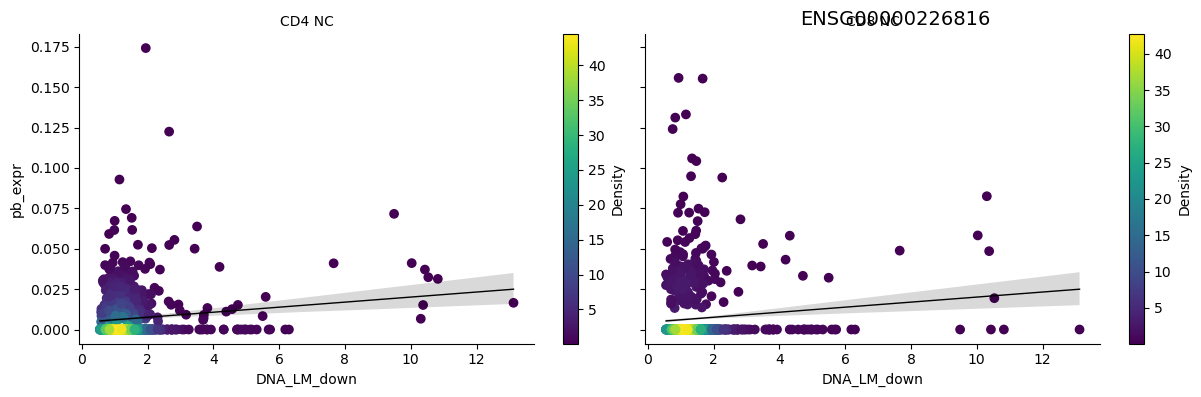

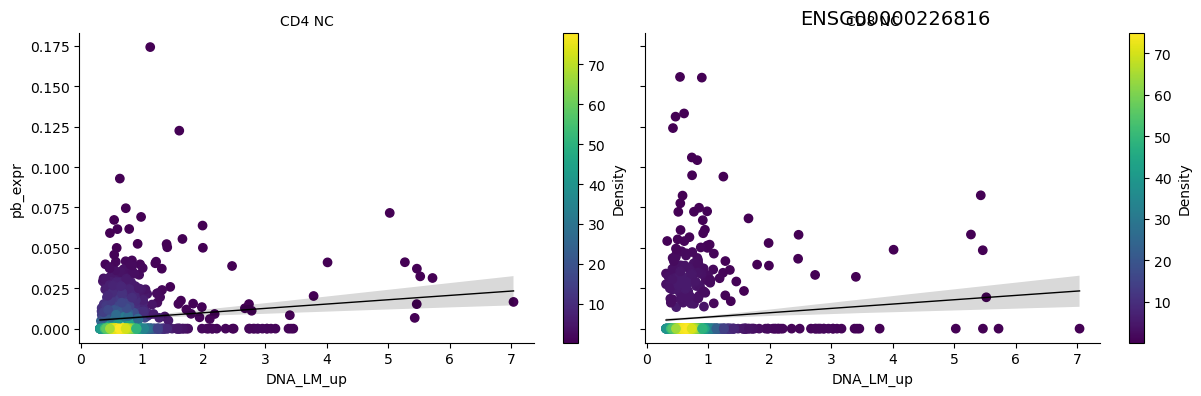

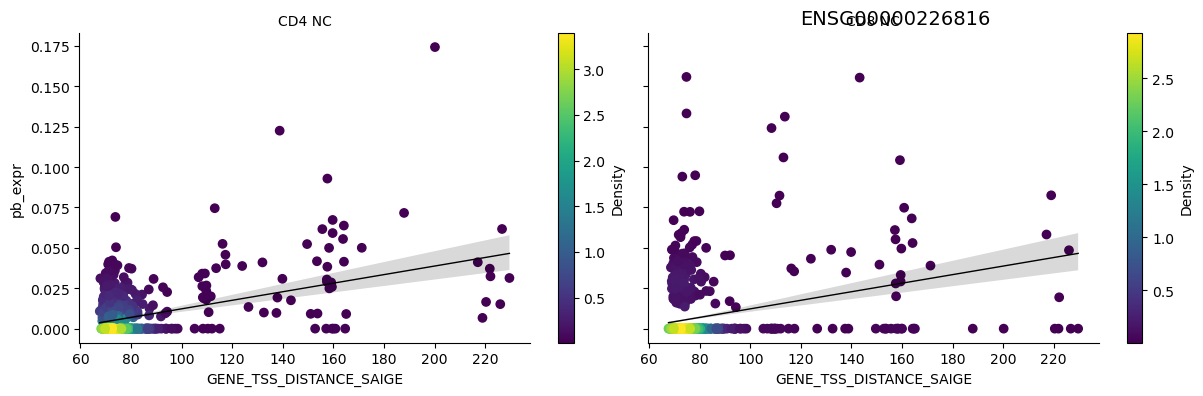

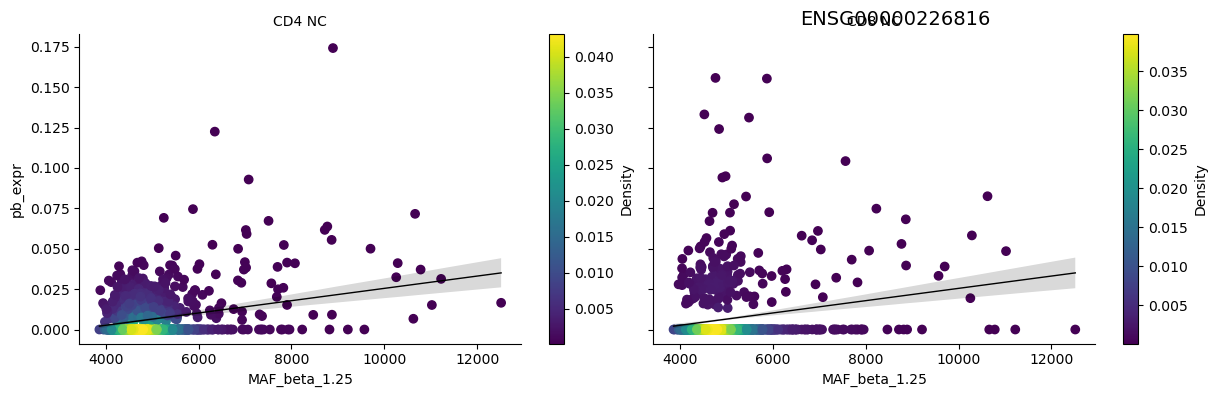

In [105]:
chrom = "7"
gene_oi = "ENSG00000226816"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

In [6]:
df_gene_oi

Number_of_Appearence Chromosomes     Cell_Types  \
burden_gene                                                        
ENSG00000226816                     9           7  CD4 NC,CD8 NC   
ENSG00000198520                     5           1  CD4 NC,CD8 NC   
ENSG00000160445                     5           9      CD8 S100B   
ENSG00000099365                     5          16         CD4 NC   
ENSG00000110203                     5          11         Mono C   
ENSG00000003147                     5           7         Mono C   
ENSG00000109184                     4           4        Mono NC   
ENSG00000151729                     4           4         Mono C   
ENSG00000132958                     4          13         CD4 NC   
ENSG00000132953                     4          13      CD8 S100B   
ENSG00000129691                     4           8         Mono C   

                                                      Burden_Types  
burden_gene                                                         
ENSG00000226816  CADD_PHRED,DNA_LM_combined,DNA_LM_down,DNA_LM_...  
ENSG00000198520  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...  
ENSG00000160445  CADD_PHRED,DNA_LM_combined,DNA_LM_down,DNA_LM_...  
ENSG00000099365  DNA_LM_combined,DNA_LM_down,DNA_LM_up,GENE_TSS...  
ENSG00000110203  CADD_PHRED,DNA_LM_down,DNA_LM_up,GENE_TSS_DIST...  
ENSG00000003147  CADD_PHRED,DNA_LM_combined,DNA_LM_down,DNA_LM_...  
ENSG00000109184  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...  
ENSG00000151729  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...  
ENSG00000132958  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...  
ENSG00000132953  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...  
ENSG00000129691  DNA_LM_combined,DNA_LM_down,DNA_LM_up,MAF_beta...

Getting PB Mono C
[2025-02-01 11:11:16,075] INFO:cellink._core.donordata: Keeping 968/981 donors
[2025-02-01 11:11:16,075] INFO:cellink._core.donordata: Dropping 13/981 donors from genetic data
[2025-02-01 11:11:16,077] INFO:cellink._core.donordata: Dropping 0/968 donors from single-cell data


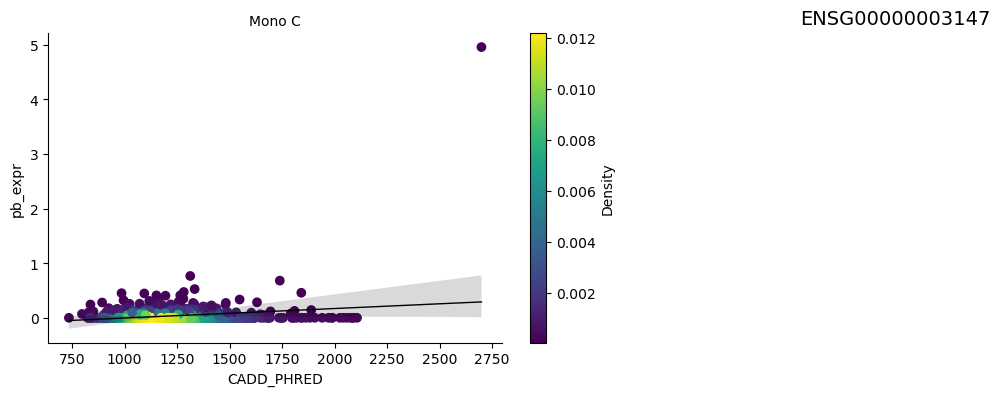

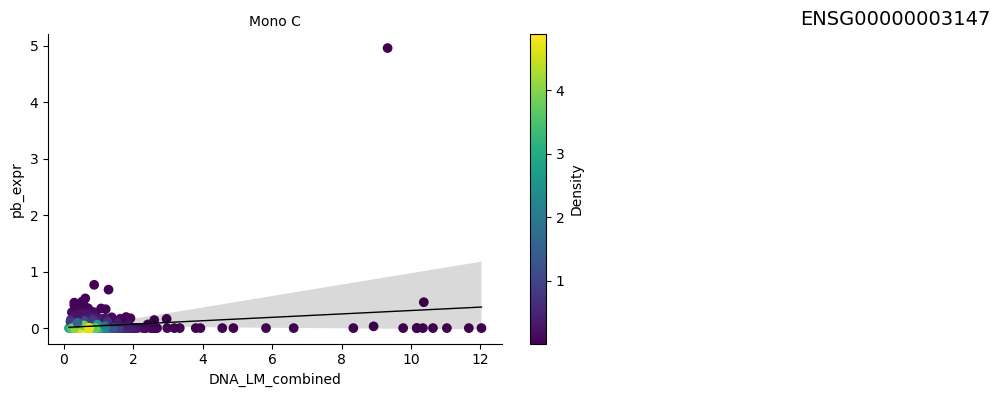

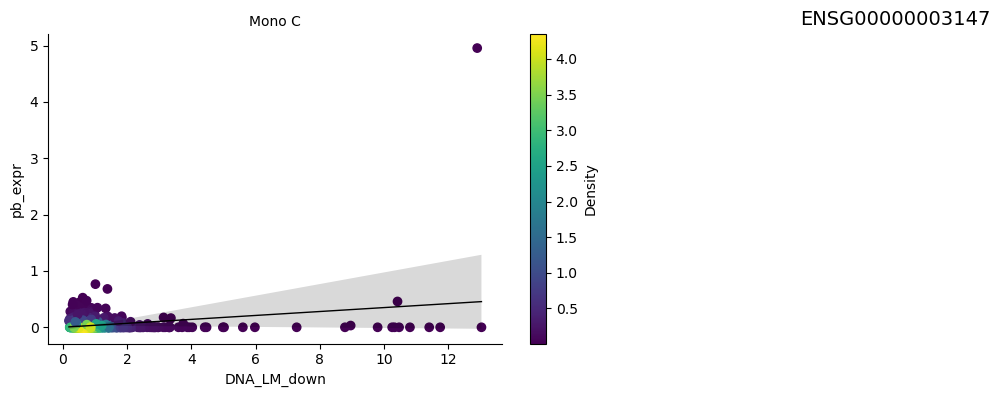

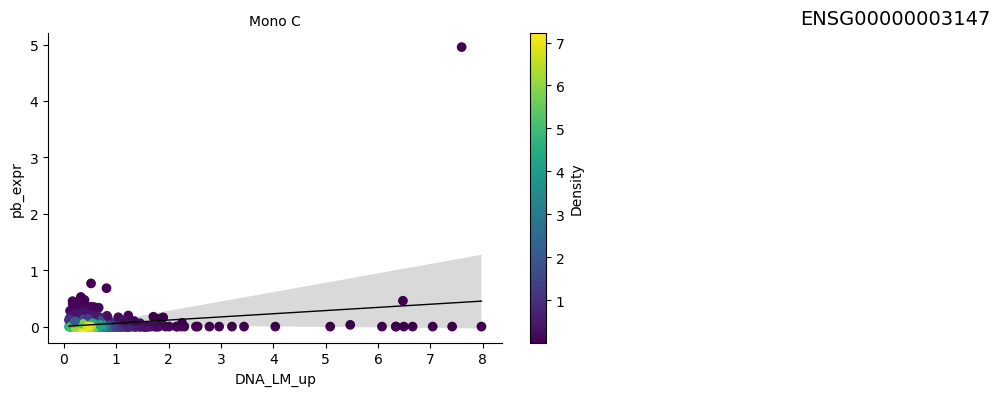

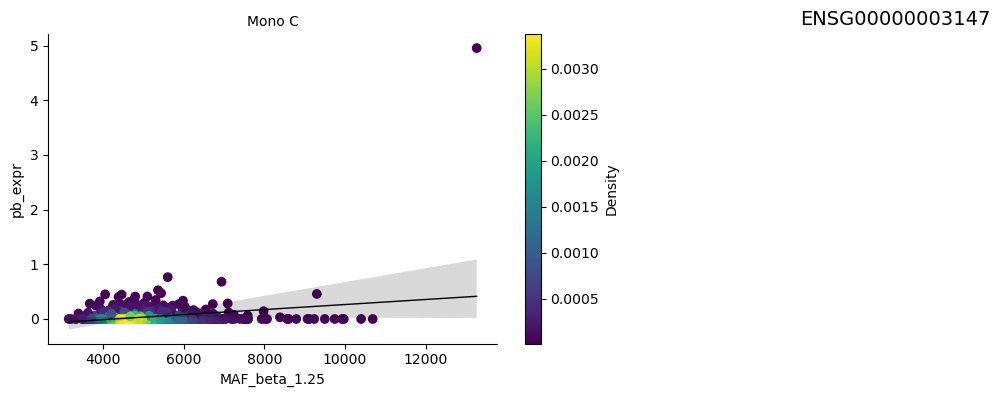

In [8]:
chrom = "7"
gene_oi = "ENSG00000003147"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB Mono NC
[2025-02-01 11:12:15,120] INFO:cellink._core.donordata: Keeping 933/981 donors
[2025-02-01 11:12:15,120] INFO:cellink._core.donordata: Dropping 48/981 donors from genetic data
[2025-02-01 11:12:15,121] INFO:cellink._core.donordata: Dropping 0/933 donors from single-cell data


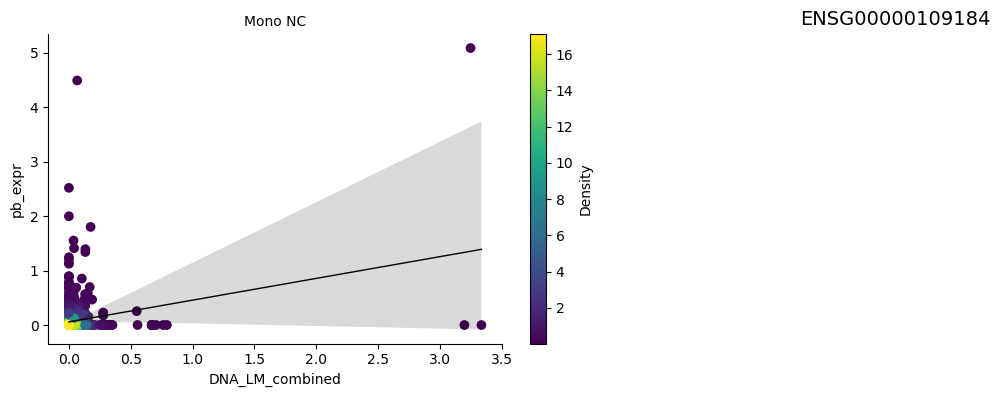

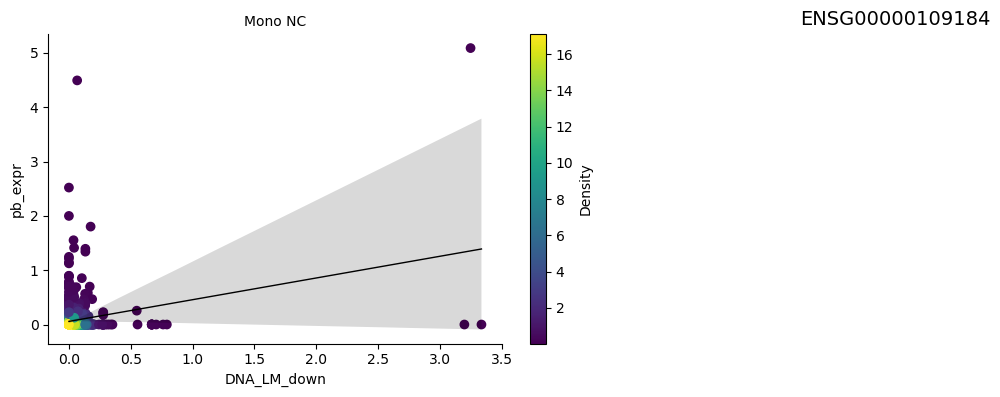

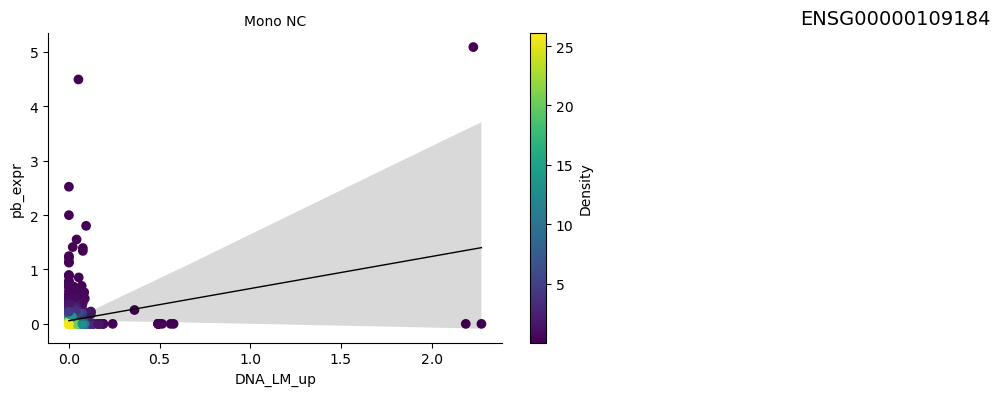

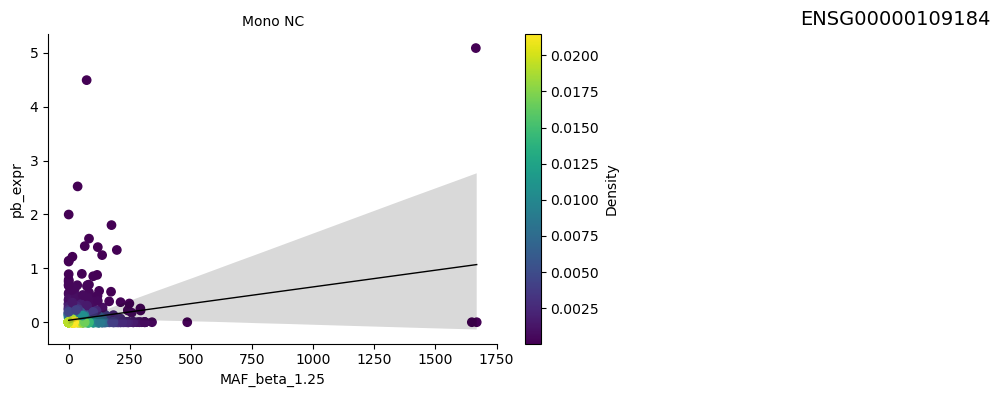

In [9]:
chrom = "4"
gene_oi = "ENSG00000109184"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB Mono C
[2025-02-01 11:13:45,123] INFO:cellink._core.donordata: Keeping 968/981 donors
[2025-02-01 11:13:45,124] INFO:cellink._core.donordata: Dropping 13/981 donors from genetic data
[2025-02-01 11:13:45,124] INFO:cellink._core.donordata: Dropping 0/968 donors from single-cell data


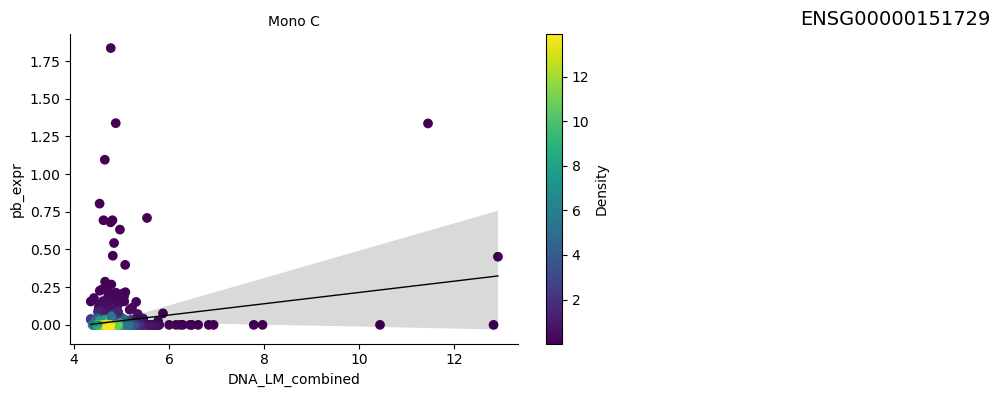

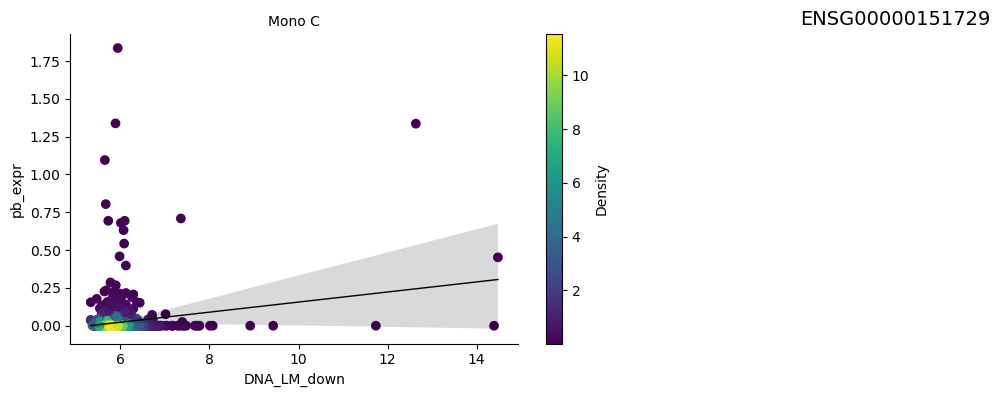

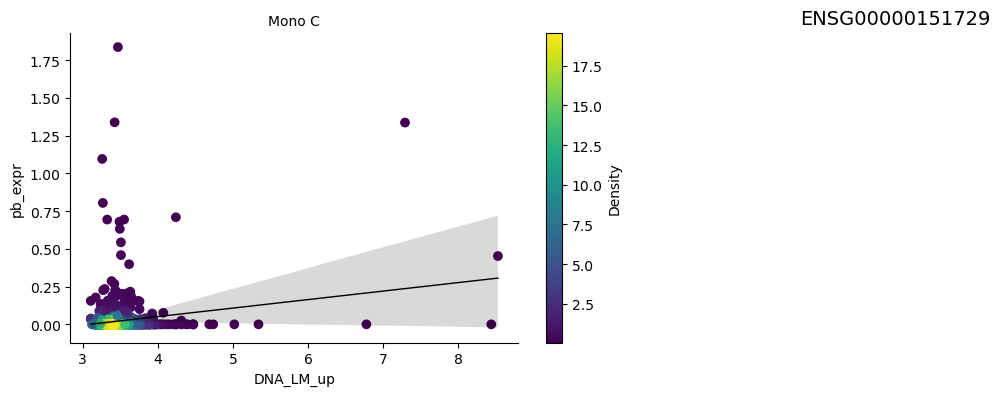

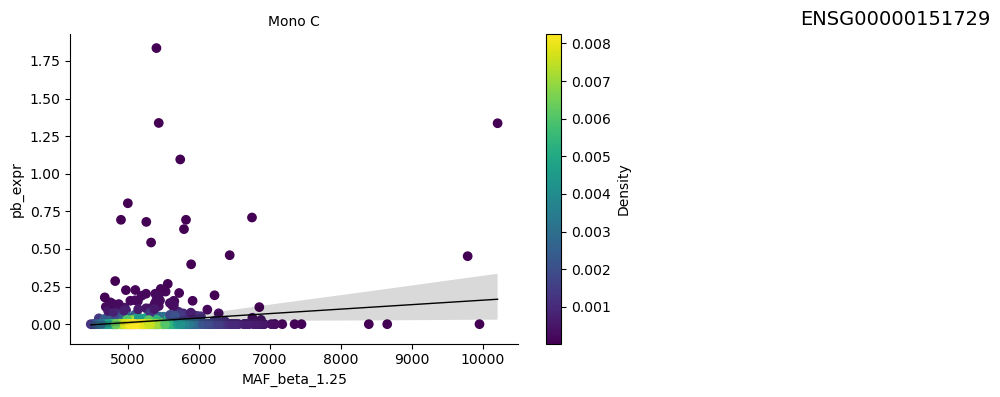

In [10]:
chrom = "4"
gene_oi = "ENSG00000151729"
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")

Getting PB Mono C
[2025-02-01 11:22:11,893] INFO:cellink._core.donordata: Keeping 968/981 donors
[2025-02-01 11:22:11,894] INFO:cellink._core.donordata: Dropping 13/981 donors from genetic data
[2025-02-01 11:22:11,894] INFO:cellink._core.donordata: Dropping 0/968 donors from single-cell data


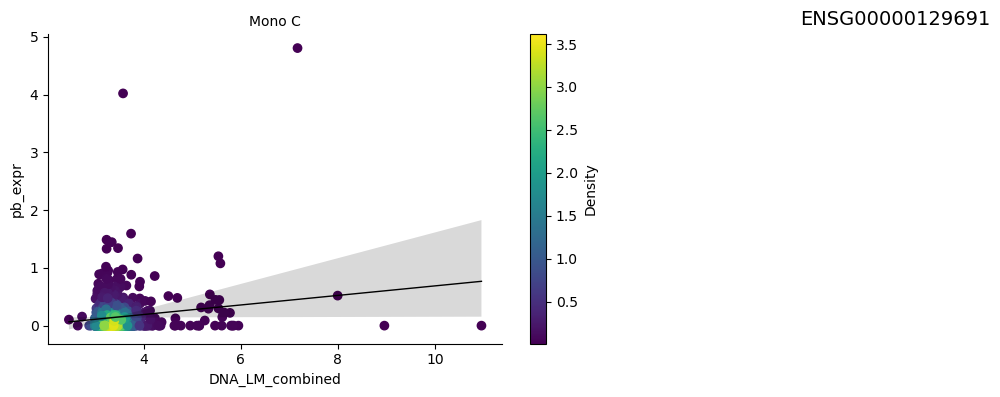

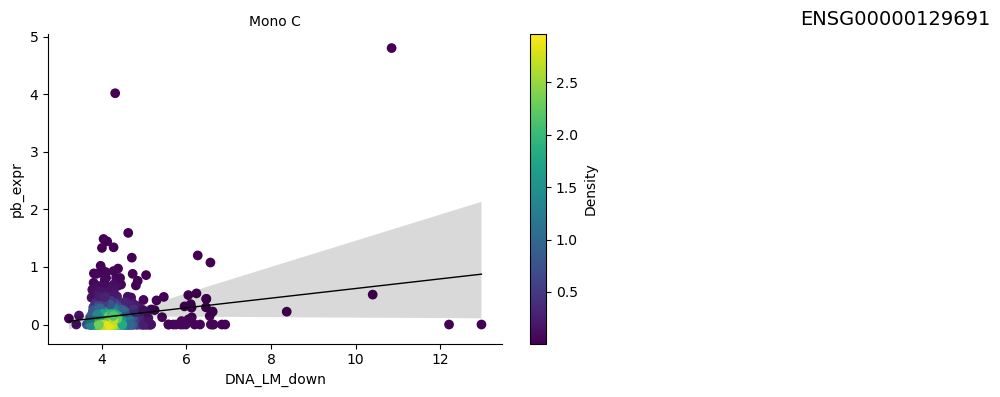

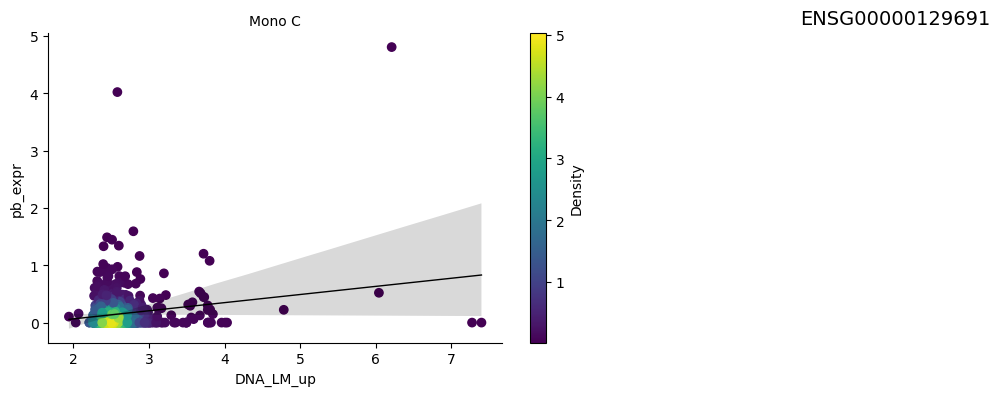

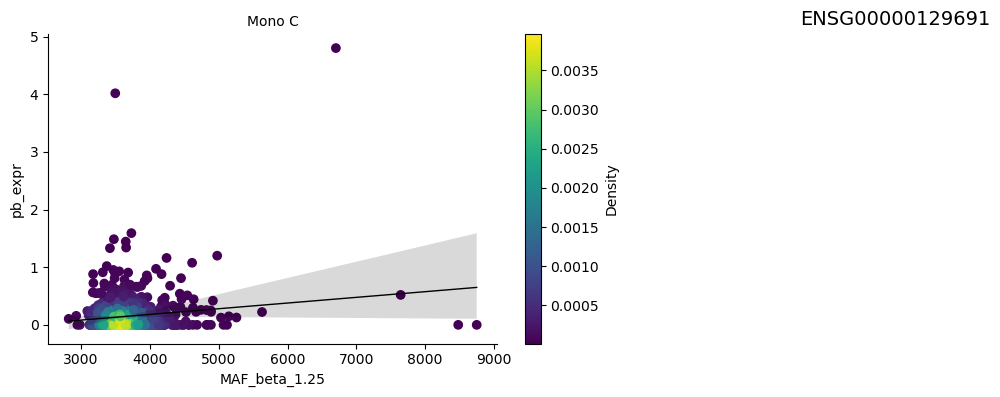

In [13]:
chrom = "8"
gene_oi = "ENSG00000129691"
data = pd.read_pickle(out_path/f"annotations/chr{chrom}_data.pkl")
data.gdata.varm["annotations_0"] = data.gdata.varm["annotations_0"].rename(columns={'DNA_LM_mixed': 'DNA_LM_combined'})
df_burdens_for_chrom = df_burdens[df_burdens["Chromosome"] == chrom]
get_pb_plots(data,
             df_burdens_for_chrom,
             eigenvec,
             chrom,
             cell_types=df_gene_oi.loc[gene_oi]["Cell_Types"].split(","),
             burden_types=df_gene_oi.loc[gene_oi]["Burden_Types"].split(","),
             gene_list=[gene_oi],
             save_dir="")